In [15]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import xgboost as xgb
from prophet import Prophet
from tqdm import tqdm
import os

# =============================================
# 1. НАСТРОЙКА ВИЗУАЛИЗАЦИИ
# =============================================
available_styles = plt.style.available
selected_style = 'seaborn-v0_8' if 'seaborn-v0_8' in available_styles else 'ggplot'
plt.style.use(selected_style)

plt.rcParams.update({
    'figure.figsize': (12, 6),
    'font.size': 12,
    'axes.titlesize': 14,
    'axes.labelsize': 12,
    'xtick.labelsize': 10,
    'ytick.labelsize': 10
})

sns.set_theme(style="whitegrid", palette="husl")

In [17]:
# =============================================
# 2. ЗАГРУЗКА ДАННЫХ
# =============================================
print("Начало загрузки данных...")

files = [
    'Parking_Violations_Issued_-_Fiscal_Year_2014__August_2013___June_2014_.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2015.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2016.csv',
    'Parking_Violations_Issued_-_Fiscal_Year_2017.csv'
]

all_data = []
for file in tqdm(files, desc="Загрузка файлов"):
    try:
        if not os.path.exists(file):
            print(f"\nФайл {file} не найден, пропускаем")
            continue
        
        df = pd.read_csv(file, usecols=['Issue Date'])
        df['Issue Date'] = pd.to_datetime(df['Issue Date'], errors='coerce')
        df = df.dropna(subset=['Issue Date'])
        
        if not df.empty:
            all_data.append(df)
        else:
            print(f"\nФайл {file} не содержит валидных дат")
            
    except Exception as e:
        print(f"\nОшибка при обработке файла {file}: {str(e)}")

if not all_data:
    raise ValueError("Не удалось загрузить ни один файл")

raw_data = pd.concat(all_data, ignore_index=True)
print(f"\nУспешно загружено {len(raw_data)} записей")

Начало загрузки данных...


Загрузка файлов: 100%|██████████| 4/4 [00:59<00:00, 14.95s/it]


Успешно загружено 42339438 записей



Подготовка данных...
Подготовлено 36415 дней данных

Визуализация сезонных паттернов...


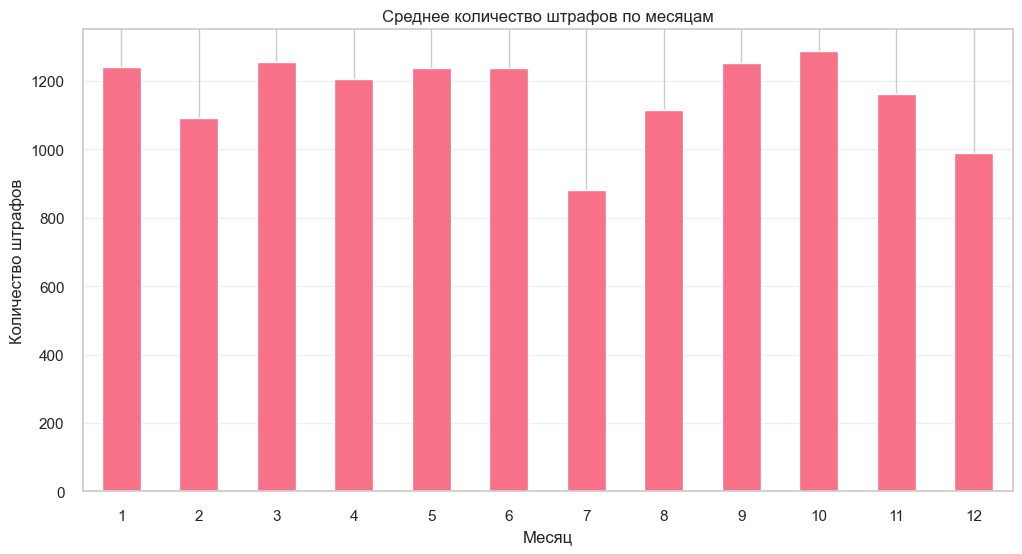

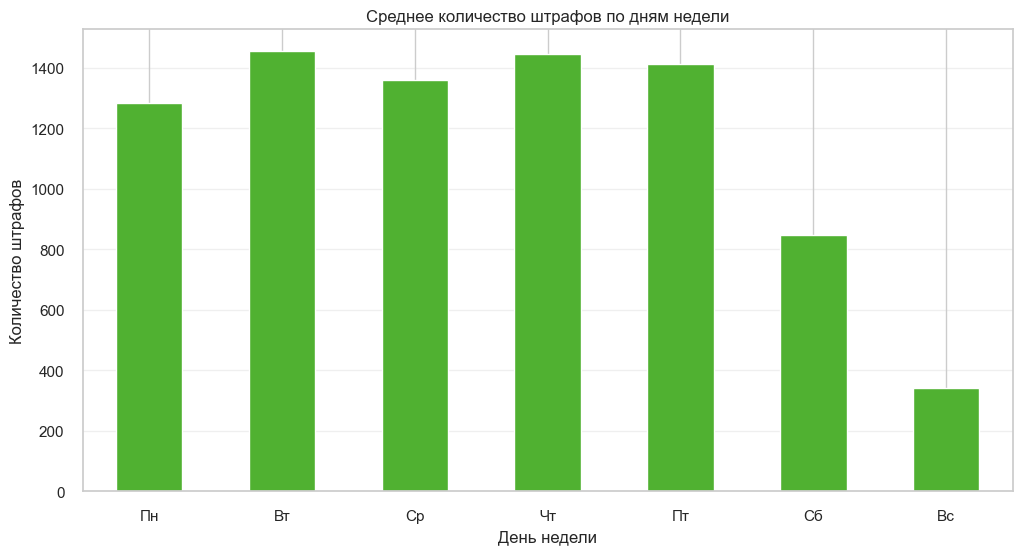

In [19]:
# =============================================
# 3. ПОДГОТОВКА ДАННЫХ
# =============================================
print("\nПодготовка данных...")

daily_counts = raw_data.resample('D', on='Issue Date').size().reset_index(name='count')
daily_counts['month'] = daily_counts['Issue Date'].dt.month
daily_counts['day_of_week'] = daily_counts['Issue Date'].dt.dayofweek
daily_counts['year'] = daily_counts['Issue Date'].dt.year

print(f"Подготовлено {len(daily_counts)} дней данных")

# =============================================
# 4. ВИЗУАЛИЗАЦИЯ СЕЗОННОСТИ
# =============================================
print("\nВизуализация сезонных паттернов...")

# По месяцам
monthly_avg = daily_counts.groupby('month')['count'].mean()
plt.figure(figsize=(12, 6))
monthly_avg.plot(kind='bar', color=sns.color_palette("husl")[0])
plt.title('Среднее количество штрафов по месяцам')
plt.xlabel('Месяц')
plt.ylabel('Количество штрафов')
plt.xticks(rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()

# По дням недели
weekday_names = ['Пн', 'Вт', 'Ср', 'Чт', 'Пт', 'Сб', 'Вс']
daily_avg = daily_counts.groupby('day_of_week')['count'].mean()
plt.figure(figsize=(12, 6))
daily_avg.plot(kind='bar', color=sns.color_palette("husl")[2])
plt.title('Среднее количество штрафов по дням недели')
plt.xlabel('День недели')
plt.ylabel('Количество штрафов')
plt.xticks(range(7), weekday_names, rotation=0)
plt.grid(axis='y', alpha=0.3)
plt.show()



Анализ с XGBoost...

Оценка модели XGBoost:
MAE: 1453.22
RMSE: 1539.85
R²: -183789968.00


<Figure size 1000x500 with 0 Axes>

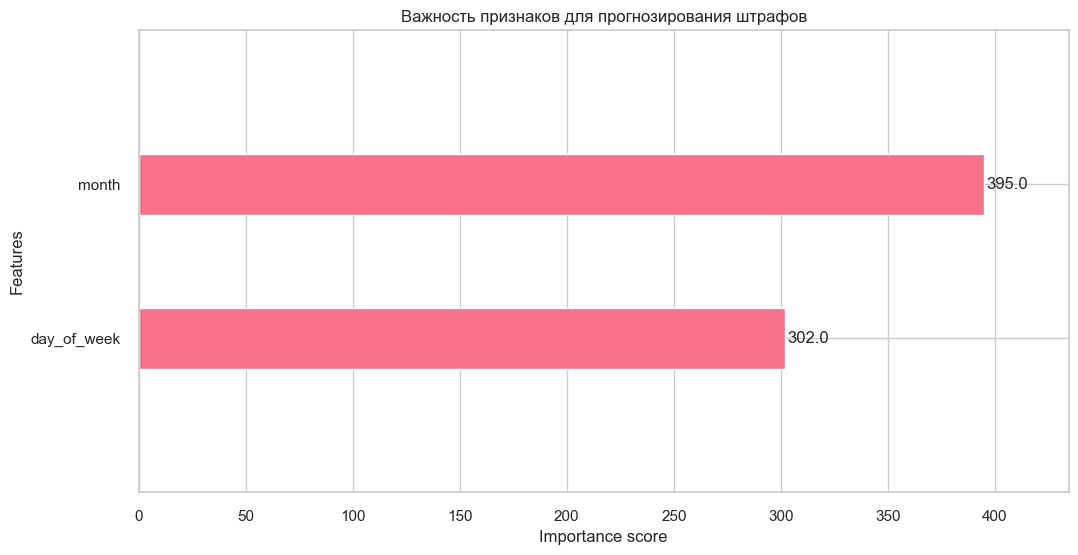

In [21]:
# =============================================
# 5. АНАЛИЗ С XGBOOST
# =============================================
print("\nАнализ с XGBoost...")

# Подготовка данных
X = daily_counts[['month', 'day_of_week']]
y = daily_counts['count']

# Разделение на train/test
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, shuffle=False)

# Обучение модели
xgb_model = xgb.XGBRegressor(
    objective='reg:squarederror',
    n_estimators=100,
    max_depth=3,
    learning_rate=0.1,
    random_state=42
)
xgb_model.fit(X_train, y_train)

# Прогнозирование и оценка
y_pred = xgb_model.predict(X_test)

print("\nОценка модели XGBoost:")
print(f"MAE: {mean_absolute_error(y_test, y_pred):.2f}")
print(f"RMSE: {np.sqrt(mean_squared_error(y_test, y_pred)):.2f}")
print(f"R²: {r2_score(y_test, y_pred):.2f}")

# Визуализация важности признаков
plt.figure(figsize=(10, 5))
xgb.plot_importance(xgb_model, height=0.4)
plt.title('Важность признаков для прогнозирования штрафов')
plt.show()



Анализ с Prophet...


01:16:00 - cmdstanpy - INFO - Chain [1] start processing
01:16:31 - cmdstanpy - INFO - Chain [1] done processing


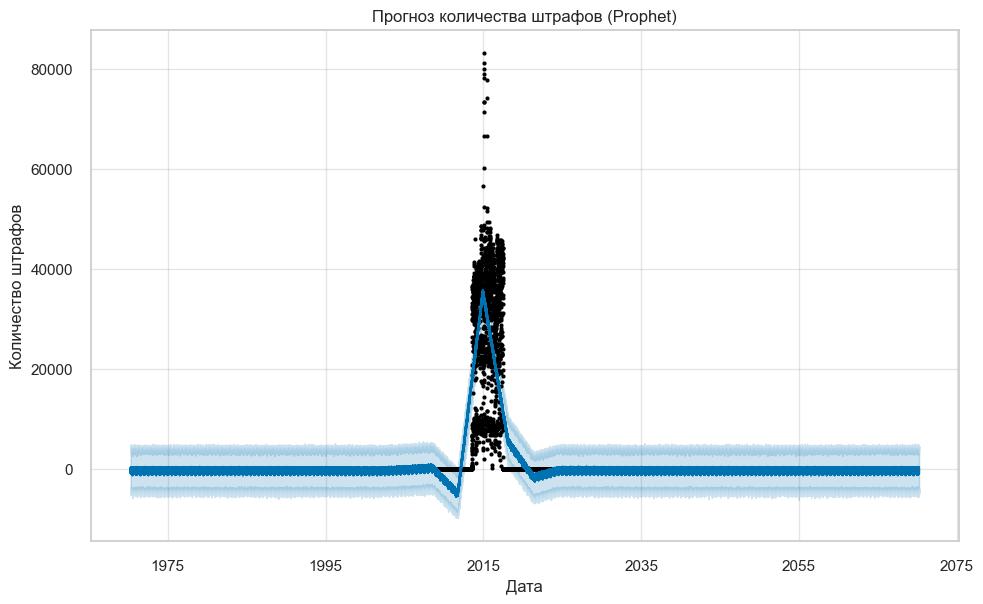

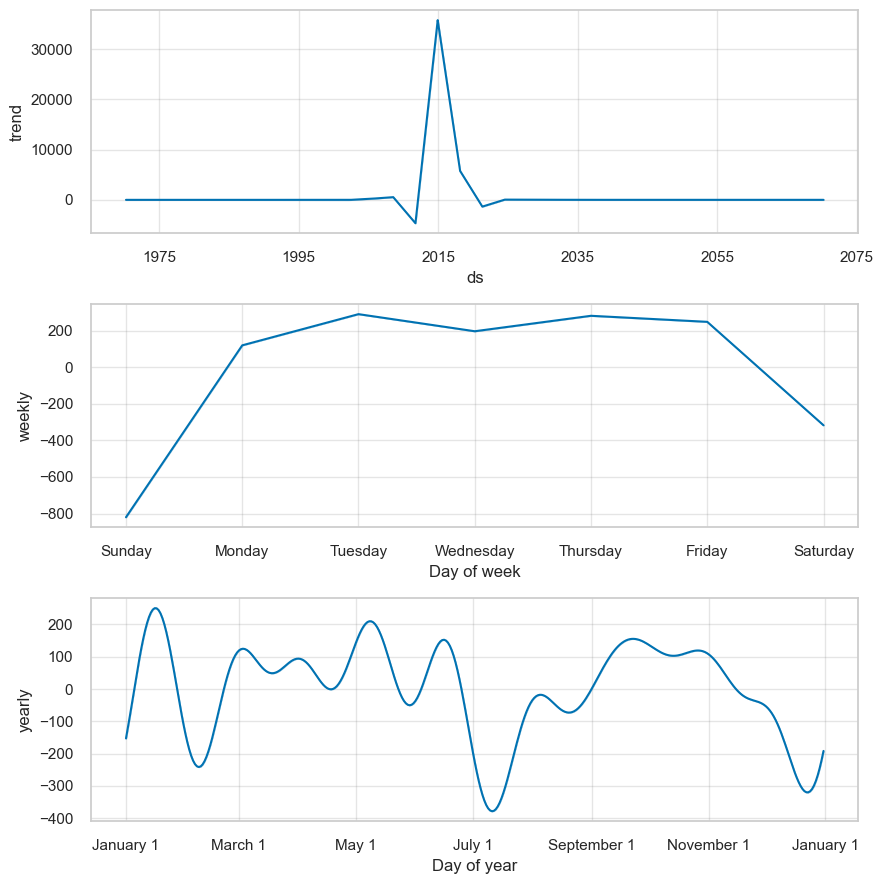


Анализ завершен успешно!


In [23]:
# =============================================
# 6. АНАЛИЗ С PROPHET
# =============================================
print("\nАнализ с Prophet...")

# Подготовка данных
prophet_df = daily_counts.rename(columns={'Issue Date': 'ds', 'count': 'y'})[['ds', 'y']]

# Создание и обучение модели
prophet_model = Prophet(
    yearly_seasonality=True,
    weekly_seasonality=True,
    daily_seasonality=False,
    changepoint_prior_scale=0.05
)
prophet_model.fit(prophet_df)

# Прогнозирование
future = prophet_model.make_future_dataframe(periods=90)  # +3 месяца
forecast = prophet_model.predict(future)

# Визуализация
fig1 = prophet_model.plot(forecast)
plt.title('Прогноз количества штрафов (Prophet)')
plt.xlabel('Дата')
plt.ylabel('Количество штрафов')
plt.show()

fig2 = prophet_model.plot_components(forecast)
plt.show()


In [25]:
import time
from sklearn.base import clone


Анализ производительности моделей...


Testing different fractions:   0%|          | 0/4 [00:00<?, ?it/s]C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
01:43:16 - cmdstanpy - INFO - Chain [1] start processing
01:43:17 - cmdstanpy - INFO - Chain [1] done processing
C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Testing different fractions:  25%|██▌       | 1/4 [00:02<00:07,  2.61s/it]C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'r

,model,fraction,n_samples,n_jobs,train_time_s,mae,rmse,r2
0,XGB,0.1,2913,-1,0.052178,0.024622,0.114820,-2.188623e-02
1,Prophet,0.1,2913,1,2.556792,0.024199,0.115912,-4.140014e-02
2,XGB,0.3,8739,-1,0.051653,0.020375,0.113841,-4.519820e-03
3,Prophet,0.3,8739,1,5.196185,0.030878,0.118185,-8.265758e-02
4,XGB,0.6,17479,-1,0.079324,2422.157447,2566.121760,-5.104092e+08
5,Prophet,0.6,17479,1,8.702751,59708.442567,62485.916120,-3.026413e+11
6,XGB,1.0,29132,-1,0.068176,1453.220103,1539.851875,-1.837900e+08
7,Prophet,1.0,29132,1,31.838861,415.858222,517.070064,-2.072348e+07


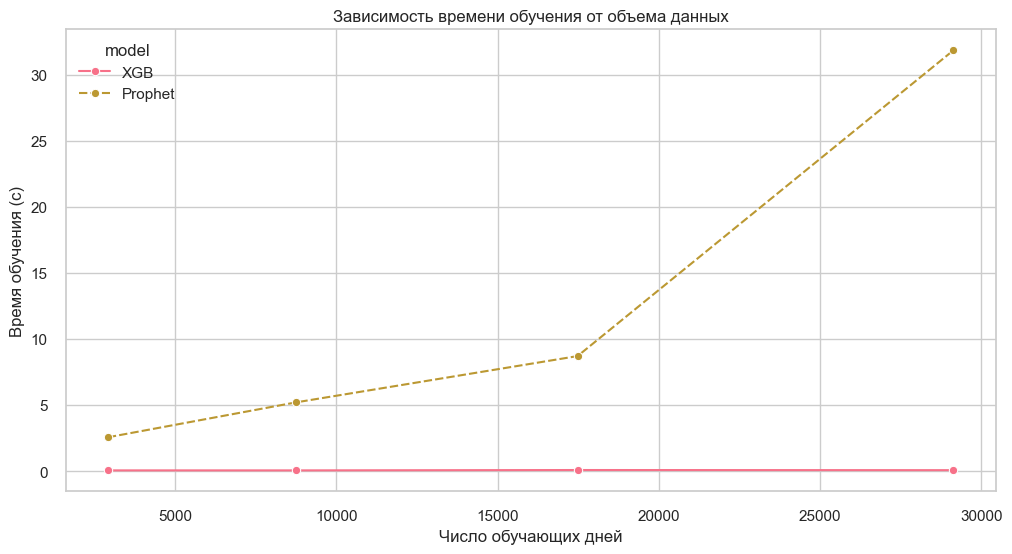

In [47]:
# =============================================
# 7. АНАЛИЗ ПРОИЗВОДИТЕЛЬНОСТИ МОДЕЛЕЙ (ИСПРАВЛЕННАЯ ВЕРСИЯ)
# =============================================
print("\nАнализ производительности моделей...")

# Разделим данные на обучающую и тестовую выборки
train_size = int(len(daily_counts) * 0.8)
train = daily_counts.iloc[:train_size]
test = daily_counts.iloc[train_size:]

# Функция для создания новых экземпляров моделей
def get_new_model(name):
    if name == 'XGB':
        return xgb.XGBRegressor(
            objective='reg:squarederror',
            n_estimators=100,
            max_depth=3,
            learning_rate=0.1,
            random_state=42,
            n_jobs=-1
        )
    elif name == 'Prophet':
        return Prophet(
            yearly_seasonality=True,
            weekly_seasonality=True,
            daily_seasonality=False,
            changepoint_prior_scale=0.05
        )
    else:
        raise ValueError(f"Unknown model name: {name}")

fractions = [0.1, 0.3, 0.6, 1.0]
results_size = []

for frac in tqdm(fractions, desc="Testing different fractions"):
    n_samples = int(len(train) * frac)
    train_sub = train.iloc[:n_samples]
    
    for name in ['XGB', 'Prophet']:
        start = time.time()
        
        if name == 'XGB':
            # Подготовка данных для XGBoost
            X_sub = train_sub[['month', 'day_of_week']]
            y_sub = train_sub['count']
            
            # Создание и обучение модели
            model = get_new_model(name)
            model.fit(X_sub, y_sub)
            
            # Оценка на тестовых данных
            X_test = test[['month', 'day_of_week']]
            y_test = test['count']
            y_pred = model.predict(X_test)
            
        else:  # Prophet
            # Подготовка данных для Prophet
            prophet_df = train_sub.rename(columns={'Issue Date': 'ds', 'count': 'y'})[['ds', 'y']]
            
            # Создание и обучение модели
            model = get_new_model(name)
            model.fit(prophet_df)
            
            # Оценка на тестовых данных
            future = model.make_future_dataframe(periods=len(test))
            forecast = model.predict(future)
            y_test = test['count'].values
            y_pred = forecast['yhat'].values[-len(test):]
        
        elapsed = time.time() - start
        
        results_size.append({
            'model': name,
            'fraction': frac,
            'n_samples': n_samples,
            'n_jobs': -1 if name == 'XGB' else 1,
            'train_time_s': elapsed,
            'mae': mean_absolute_error(y_test, y_pred),
            'rmse': mean_squared_error(y_test, y_pred, squared=False),
            'r2': r2_score(y_test, y_pred)
        })

df_size = pd.DataFrame(results_size)
display(df_size)

# Визуализация результатов (остается без изменений)
plt.figure(figsize=(12, 6))
sns.lineplot(data=df_size, x='n_samples', y='train_time_s', hue='model', marker='o', style='model')
plt.xlabel('Число обучающих дней')
plt.ylabel('Время обучения (с)')
plt.title('Зависимость времени обучения от объема данных')
plt.grid(True)
plt.show()


In [53]:
X = daily_counts[['month', 'day_of_week']]
y = daily_counts['count']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=False)

# =============================================
# 8. АНАЛИЗ ЗАВИСИМОСТИ ВРЕМЕНИ ОТ ЧИСЛА ПОТОКОВ
# =============================================
print("\nАнализ зависимости времени обучения от числа потоков...")

# Конфигурация теста
cores = [1, 2, 4, 8, -1]  # -1 означает все доступные ядра
cpu_count = os.cpu_count()
results = []

for n_jobs in tqdm(cores, desc="Тестирование разных n_jobs"):
    # Создаем новую модель для каждого теста
    model = xgb.XGBRegressor(
        objective='reg:squarederror',
        n_estimators=100,
        max_depth=3,
        learning_rate=0.1,
        random_state=42,
        n_jobs=n_jobs
    )
    
    # Замер времени обучения
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    
    # Оценка качества
    y_pred = model.predict(X_test)
    
    # Сохраняем результаты
    actual_cores = cpu_count if n_jobs == -1 else min(n_jobs, cpu_count)
    results.append({
        'n_jobs': n_jobs,
        'actual_cores': actual_cores,
        'train_time': train_time,
        'speedup': results[0]['train_time']/train_time if results else 1.0,
        'mae': mean_absolute_error(y_test, y_pred),
        'rmse': mean_squared_error(y_test, y_pred, squared=False),
        'r2': r2_score(y_test, y_pred)
    })

# Конвертируем в DataFrame
results_df = pd.DataFrame(results)



Анализ зависимости времени обучения от числа потоков...


Тестирование разных n_jobs:   0%|          | 0/5 [00:00<?, ?it/s]C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Тестирование разных n_jobs:  20%|██        | 1/5 [00:00<00:00,  5.83it/s]C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
C:\Users\kotlo\anaconda3\Lib\site-packages\sklearn\metrics\_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
Тестирование разных n_jobs:  60%|██████    | 3/5 [00:00<00:00, 10.02it/s]


Визуализация результатов...


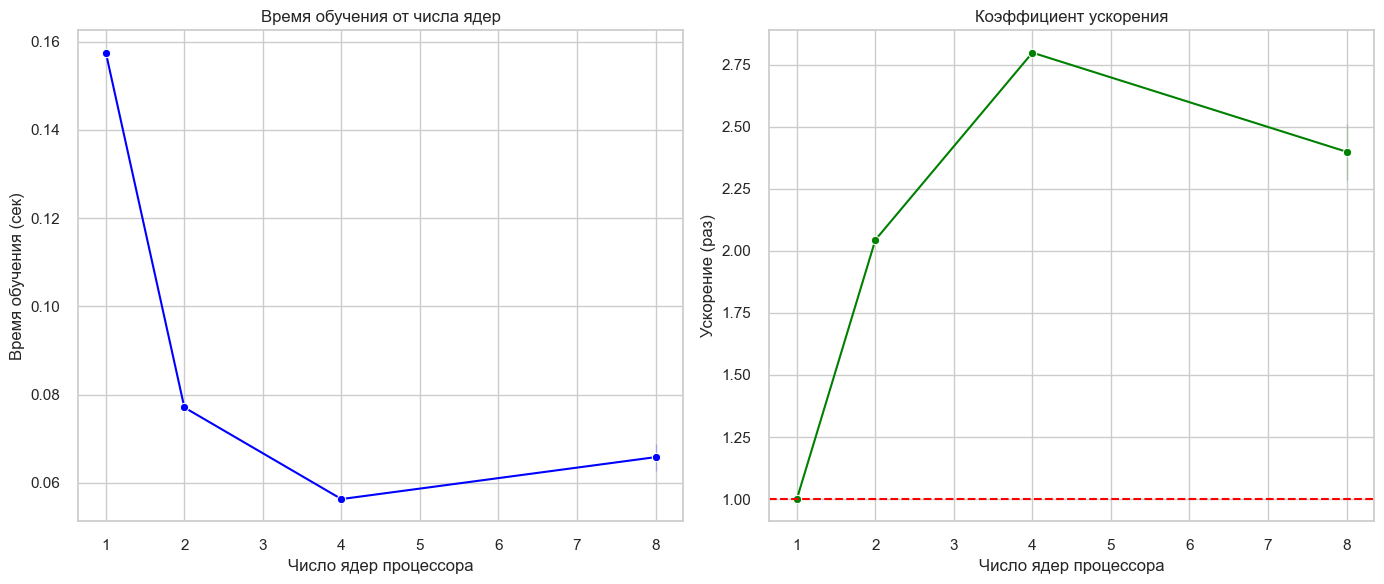


Результаты тестирования:


,n_jobs_label,actual_cores,train_time,speedup,mae,rmse,r2
0,1,1,0.16 сек,1.00x,1453.22,1539.85,-183789968.000
1,2,2,0.08 сек,2.04x,1453.22,1539.85,-183789968.000
2,4,4,0.06 сек,2.80x,1453.22,1539.85,-183789968.000
3,8,8,0.07 сек,2.29x,1453.22,1539.85,-183789968.000
4,all,8,0.06 сек,2.51x,1453.22,1539.85,-183789968.000


In [55]:
# =============================================
# 3. ВИЗУАЛИЗАЦИЯ РЕЗУЛЬТАТОВ
# =============================================
print("\nВизуализация результатов...")

plt.figure(figsize=(14, 6))

# График времени обучения
plt.subplot(1, 2, 1)
sns.lineplot(
    data=results_df,
    x='actual_cores',
    y='train_time',
    marker='o',
    color='blue'
)
plt.title('Время обучения от числа ядер')
plt.xlabel('Число ядер процессора')
plt.ylabel('Время обучения (сек)')
plt.grid(True)

# График ускорения
plt.subplot(1, 2, 2)
sns.lineplot(
    data=results_df,
    x='actual_cores',
    y='speedup',
    marker='o',
    color='green'
)
plt.title('Коэффициент ускорения')
plt.xlabel('Число ядер процессора')
plt.ylabel('Ускорение (раз)')
plt.axhline(y=1, color='red', linestyle='--')
plt.grid(True)

plt.tight_layout()
plt.show()

# Таблица с результатами
print("\nРезультаты тестирования:")
results_df['n_jobs_label'] = results_df['n_jobs'].apply(lambda x: 'all' if x == -1 else str(x))
display(results_df[['n_jobs_label', 'actual_cores', 'train_time', 'speedup', 'mae', 'rmse', 'r2']]
       .sort_values('actual_cores')
       .style
       .format({'train_time': '{:.2f} сек', 'speedup': '{:.2f}x', 'mae': '{:.2f}', 'rmse': '{:.2f}', 'r2': '{:.3f}'})
       .background_gradient(cmap='Blues', subset=['speedup'])
       .set_caption('Зависимость производительности от числа потоков'))
